<a href="https://colab.research.google.com/github/SaiRajesh228/DeepLearningAssignment1/blob/main/DA6401_ASSIGNMENT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create sweep with ID: rpd6rtit
Sweep URL: https://wandb.ai/karapa-rajesh-iit-madras/DeepLearning/sweeps/rpd6rtit


wandb: Agent Starting Run: v6f3vqm7 with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 64
wandb: 	hiddenlayers: 3
wandb: 	hiddennodes: 256
wandb: 	initializer: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	loss: cross_entropy
wandb: 	num_epochs: 15
wandb: 	opt: nesterov


Epoch 1: Avg Loss 0.9152, Validation Acc 0.8033
Epoch 2: Avg Loss 0.5618, Validation Acc 0.8240
Epoch 3: Avg Loss 0.4941, Validation Acc 0.8340
Epoch 4: Avg Loss 0.4606, Validation Acc 0.8422
Epoch 5: Avg Loss 0.4370, Validation Acc 0.8477
Epoch 6: Avg Loss 0.4216, Validation Acc 0.8510
Epoch 7: Avg Loss 0.4079, Validation Acc 0.8512
Epoch 8: Avg Loss 0.3967, Validation Acc 0.8560
Epoch 9: Avg Loss 0.3893, Validation Acc 0.8613
Epoch 10: Avg Loss 0.3795, Validation Acc 0.8548
Epoch 11: Avg Loss 0.3713, Validation Acc 0.8612
Epoch 12: Avg Loss 0.3650, Validation Acc 0.8638
Epoch 13: Avg Loss 0.3587, Validation Acc 0.8652
Epoch 14: Avg Loss 0.3539, Validation Acc 0.8658
Epoch 15: Avg Loss 0.3479, Validation Acc 0.8640
Final Test Accuracy: 0.8616


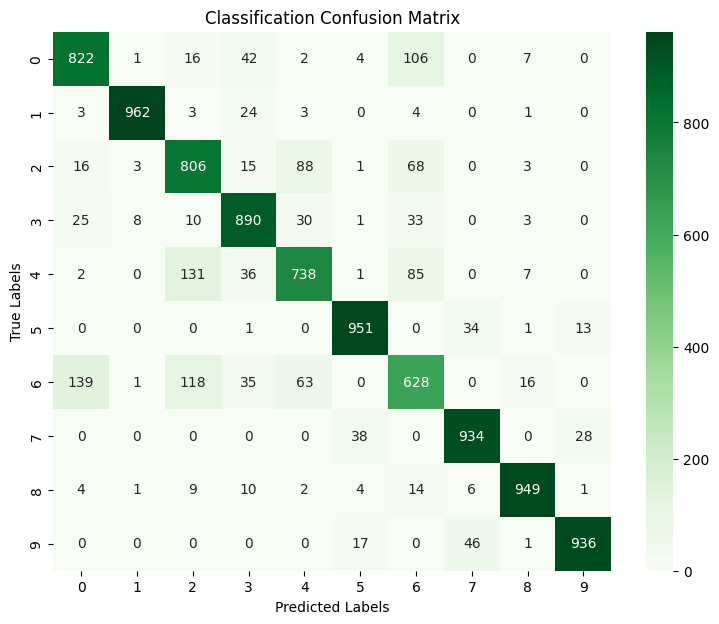

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
test_accuracy,▁
val_accuracy,▁▃▄▅▆▆▆▇▇▇▇████
epoch,15
loss,0.34789
test_accuracy,0.8616
val_accuracy,0.864


wandb: Agent Starting Run: 2mf2hkit with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 128
wandb: 	hiddenlayers: 4
wandb: 	hiddennodes: 128
wandb: 	initializer: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	loss: cross_entropy
wandb: 	num_epochs: 10
wandb: 	opt: adam


Epoch 1: Avg Loss 0.5601, Validation Acc 0.8527
Epoch 2: Avg Loss 0.3924, Validation Acc 0.8618
Epoch 3: Avg Loss 0.3492, Validation Acc 0.8700
Epoch 4: Avg Loss 0.3233, Validation Acc 0.8730
Epoch 5: Avg Loss 0.3080, Validation Acc 0.8783
Epoch 6: Avg Loss 0.2848, Validation Acc 0.8802
Epoch 7: Avg Loss 0.2712, Validation Acc 0.8817
Epoch 8: Avg Loss 0.2618, Validation Acc 0.8820
Epoch 9: Avg Loss 0.2514, Validation Acc 0.8833
Epoch 10: Avg Loss 0.2400, Validation Acc 0.8753
Final Test Accuracy: 0.8678


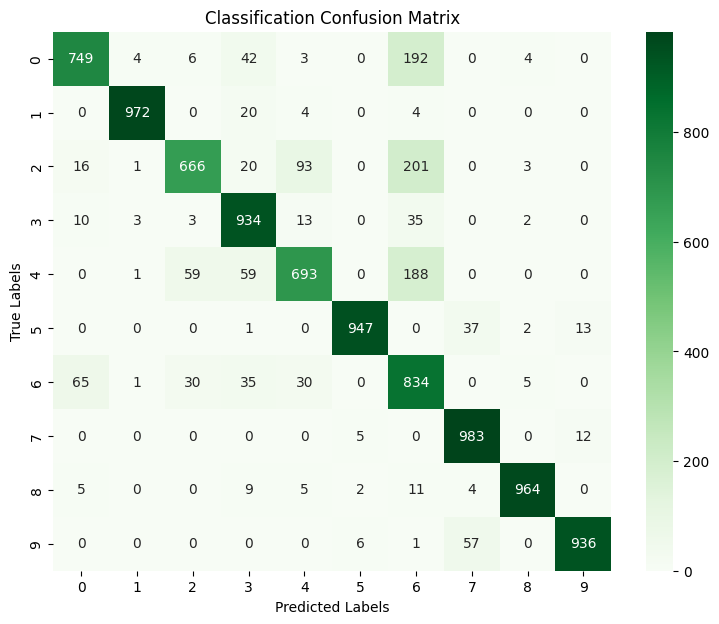

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
test_accuracy,▁
val_accuracy,▁▃▅▆▇▇███▆
epoch,10
loss,0.23997
test_accuracy,0.8678
val_accuracy,0.87533


wandb: Agent Starting Run: guda5eda with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 64
wandb: 	hiddenlayers: 5
wandb: 	hiddennodes: 128
wandb: 	initializer: Xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	num_epochs: 15
wandb: 	opt: nesterov


Epoch 1: Avg Loss 0.7305, Validation Acc 0.8273
Epoch 2: Avg Loss 0.4651, Validation Acc 0.8415
Epoch 3: Avg Loss 0.4218, Validation Acc 0.8502
Epoch 4: Avg Loss 0.3939, Validation Acc 0.8582
Epoch 5: Avg Loss 0.3751, Validation Acc 0.8643
Epoch 6: Avg Loss 0.3595, Validation Acc 0.8657
Epoch 7: Avg Loss 0.3452, Validation Acc 0.8675
Epoch 8: Avg Loss 0.3350, Validation Acc 0.8633
Epoch 9: Avg Loss 0.3231, Validation Acc 0.8677
Epoch 10: Avg Loss 0.3139, Validation Acc 0.8705
Epoch 11: Avg Loss 0.3053, Validation Acc 0.8705
Epoch 12: Avg Loss 0.2983, Validation Acc 0.8740
Epoch 13: Avg Loss 0.2905, Validation Acc 0.8733
Epoch 14: Avg Loss 0.2843, Validation Acc 0.8732
Epoch 15: Avg Loss 0.2796, Validation Acc 0.8740
Final Test Accuracy: 0.8730


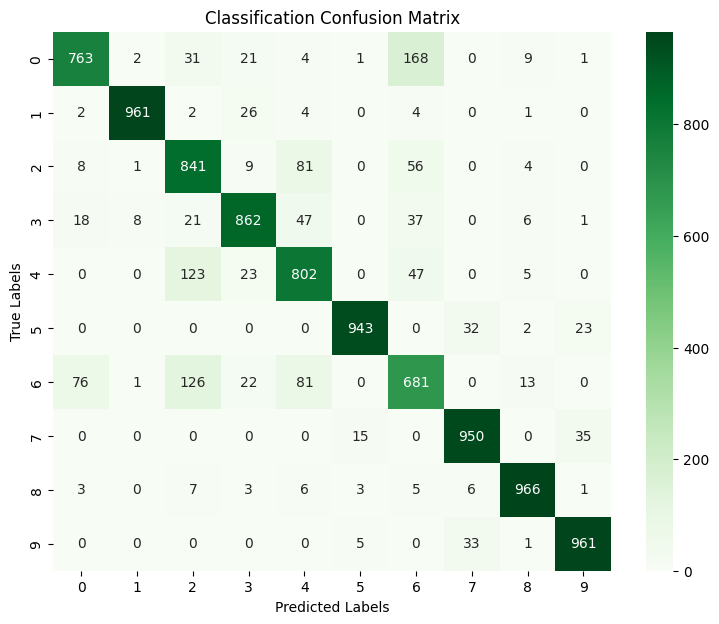

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
test_accuracy,▁
val_accuracy,▁▃▄▆▇▇▇▆▇▇▇████
epoch,15
loss,0.27958
test_accuracy,0.873
val_accuracy,0.874


wandb: Agent Starting Run: xaa05pot with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 128
wandb: 	hiddenlayers: 3
wandb: 	hiddennodes: 128
wandb: 	initializer: Xavier
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	num_epochs: 10
wandb: 	opt: nesterov


Epoch 1: Avg Loss 1.0323, Validation Acc 0.7802
Epoch 2: Avg Loss 0.5920, Validation Acc 0.8153
Epoch 3: Avg Loss 0.5136, Validation Acc 0.8252
Epoch 4: Avg Loss 0.4780, Validation Acc 0.8302
Epoch 5: Avg Loss 0.4562, Validation Acc 0.8368
Epoch 6: Avg Loss 0.4390, Validation Acc 0.8440
Epoch 7: Avg Loss 0.4255, Validation Acc 0.8475
Epoch 8: Avg Loss 0.4156, Validation Acc 0.8517
Epoch 9: Avg Loss 0.4047, Validation Acc 0.8523
Epoch 10: Avg Loss 0.3968, Validation Acc 0.8557
Final Test Accuracy: 0.8489


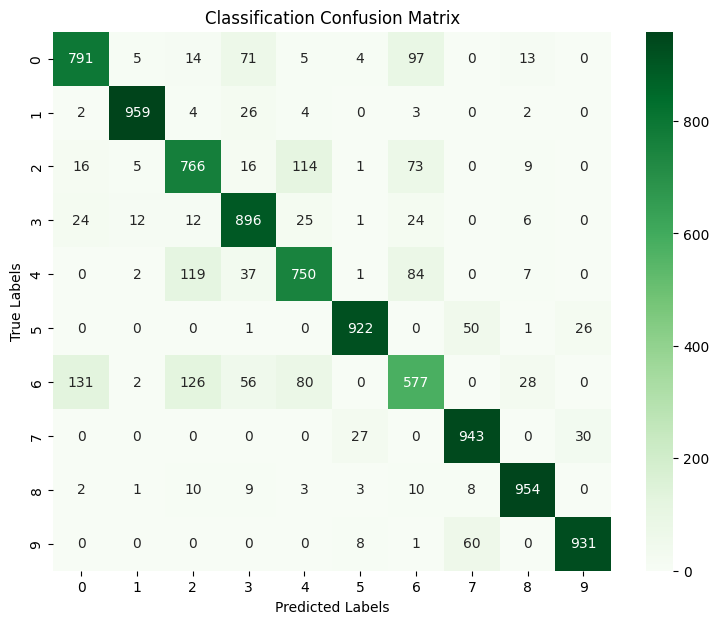

epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
test_accuracy,▁
val_accuracy,▁▄▅▆▆▇▇███
epoch,10
loss,0.39682
test_accuracy,0.8489
val_accuracy,0.85567


wandb: Agent Starting Run: oo0ejwgn with config:
wandb: 	activation_func: relu
wandb: 	batch_size: 128
wandb: 	hiddenlayers: 3
wandb: 	hiddennodes: 128
wandb: 	initializer: Xavier
wandb: 	learning_rate: 0.0005
wandb: 	loss: cross_entropy
wandb: 	num_epochs: 15
wandb: 	opt: nesterov


Epoch 1: Avg Loss 1.2773, Validation Acc 0.7292
Epoch 2: Avg Loss 0.7284, Validation Acc 0.7805
Epoch 3: Avg Loss 0.6155, Validation Acc 0.8025
Epoch 4: Avg Loss 0.5573, Validation Acc 0.8157
Epoch 5: Avg Loss 0.5204, Validation Acc 0.8227
Epoch 6: Avg Loss 0.4950, Validation Acc 0.8320
Epoch 7: Avg Loss 0.4771, Validation Acc 0.8337
Epoch 8: Avg Loss 0.4626, Validation Acc 0.8372
Epoch 9: Avg Loss 0.4509, Validation Acc 0.8397
Epoch 10: Avg Loss 0.4407, Validation Acc 0.8392
Epoch 11: Avg Loss 0.4324, Validation Acc 0.8405
Epoch 12: Avg Loss 0.4243, Validation Acc 0.8445
Epoch 13: Avg Loss 0.4173, Validation Acc 0.8478
Epoch 14: Avg Loss 0.4112, Validation Acc 0.8523
Epoch 15: Avg Loss 0.4048, Validation Acc 0.8512
Final Test Accuracy: 0.8454


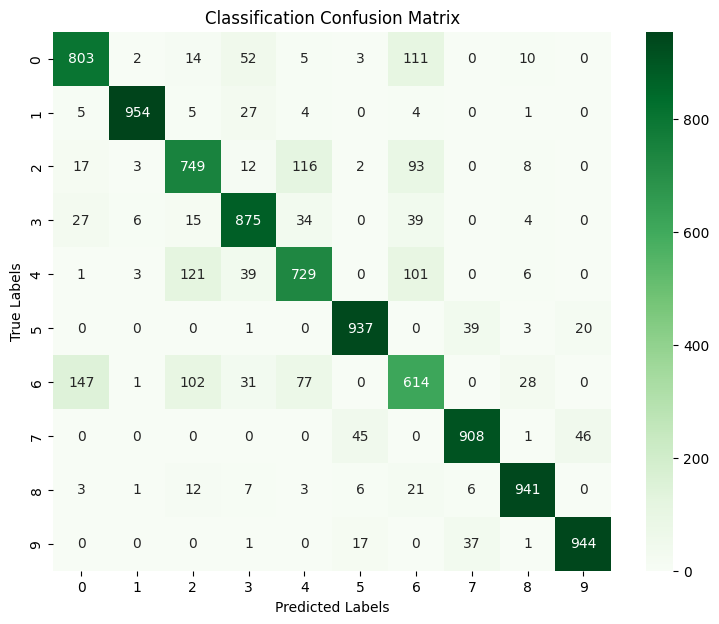

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
test_accuracy,▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇████
epoch,15
loss,0.40476
test_accuracy,0.8454
val_accuracy,0.85117


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist

# -----------------------
# Neural operations
def linear(z):
    return np.maximum(0, z)
def linear_grad(z):
    return (z > 0) * 1.0
def logistic(z):
    return 1 / (1 + np.exp(-z))
def logistic_grad(z):
    s = logistic(z)
    return s * (1 - s)
def hyperbolic(z):
    return np.tanh(z)
def hyperbolic_grad(z):
    return 1 - np.tanh(z)**2

neural_ops = {
    "relu": (linear, linear_grad),
    "sigmoid": (logistic, logistic_grad),
    "tanh": (hyperbolic, hyperbolic_grad)
}

# -----------------------
# Deep Neural Network Class
class DeepNeuralNet:
    def __init__(self, input_dim, hidden_dims, output_dim, activation="relu", init_scheme="Xavier"):
        self.layer_count = len(hidden_dims) + 1
        self.activation = activation
        self.weights = []
        self.biases = []

        dims = [input_dim] + hidden_dims + [output_dim]
        for i in range(self.layer_count):
            if init_scheme == "Xavier":
                # Proper initialization for activation type
                if activation in ["tanh", "sigmoid"]:
                    scale = np.sqrt(2. / (dims[i] + dims[i+1]))  # Xavier
                else:  # ReLU
                    scale = np.sqrt(2. / dims[i])  # He initialization
                W = np.random.randn(dims[i], dims[i+1]) * scale
            else:
                W = np.random.randn(dims[i], dims[i+1]) * 0.01
            b = np.zeros((1, dims[i+1]))
            self.weights.append(W)
            self.biases.append(b)

    def predict(self, X):
        activate, _ = neural_ops[self.activation]
        self.z_records = []
        self.a_records = [X]
        A = X
        for idx in range(self.layer_count):
            Z = A.dot(self.weights[idx]) + self.biases[idx]
            self.z_records.append(Z)
            if idx == self.layer_count - 1:
                shifted = Z - np.max(Z, axis=1, keepdims=True)
                exp = np.exp(shifted)
                A = exp / np.sum(exp, axis=1, keepdims=True)
            else:
                A = activate(Z)
            self.a_records.append(A)
        return A

    def calculate_cost(self, Y_hat, Y_real, cost_type="cross_entropy"):
        m = Y_real.shape[0]
        if cost_type == "cross_entropy":
            return -np.sum(Y_real * np.log(Y_hat + 1e-8)) / m
        elif cost_type == "mean_squared_error":
            return np.sum((Y_real - Y_hat)**2) / (2 * m)

    def compute_gradients(self, X, Y, cost_type="cross_entropy"):
        m = X.shape[0]
        grad_weights = [None] * self.layer_count
        grad_biases = [None] * self.layer_count

        final_act = self.a_records[-1]
        if cost_type == "cross_entropy":
            delta = final_act - Y
        elif cost_type == "mean_squared_error":
            delta = (final_act - Y)

        for idx in reversed(range(self.layer_count)):
            if idx == self.layer_count - 1:
                dZ = delta
            else:
                _, grad_func = neural_ops[self.activation]
                dZ = delta * grad_func(self.z_records[idx])
            prev_act = self.a_records[idx]
            grad_weights[idx] = prev_act.T.dot(dZ) / m
            grad_biases[idx] = np.sum(dZ, axis=0, keepdims=True) / m
            if idx > 0:
                delta = dZ.dot(self.weights[idx].T)
        return grad_weights, grad_biases

    def adjust_params(self, grad_w, grad_b, optim, settings, states):
        lr = settings.learning_rate

        if optim == "sgd":
            for i in range(self.layer_count):
                self.weights[i] -= lr * grad_w[i]
                self.biases[i] -= lr * grad_b[i]

        elif optim == "nesterov":
            if "nesterov" not in states:
                states["nesterov"] = {
                    "v_w": [np.zeros_like(w) for w in self.weights],
                    "v_b": [np.zeros_like(b) for b in self.biases]
                }
            momentum = 0.9
            for i in range(self.layer_count):
                # Correct Nesterov implementation
                states["nesterov"]["v_w"][i] = momentum * states["nesterov"]["v_w"][i] + grad_w[i]
                self.weights[i] -= lr * (momentum * states["nesterov"]["v_w"][i] + grad_w[i])

                states["nesterov"]["v_b"][i] = momentum * states["nesterov"]["v_b"][i] + grad_b[i]
                self.biases[i] -= lr * (momentum * states["nesterov"]["v_b"][i] + grad_b[i])

        elif optim == "rmsprop":
            if "rmsprop" not in states:
                states["rmsprop"] = {
                    "cache_w": [np.zeros_like(w) for w in self.weights],
                    "cache_b": [np.zeros_like(b) for b in self.biases]
                }
            gamma = 0.9
            eps = 1e-8
            for i in range(self.layer_count):
                states["rmsprop"]["cache_w"][i] = gamma * states["rmsprop"]["cache_w"][i] + (1 - gamma) * (grad_w[i]**2)
                self.weights[i] -= lr * grad_w[i] / (np.sqrt(states["rmsprop"]["cache_w"][i]) + eps)

                states["rmsprop"]["cache_b"][i] = gamma * states["rmsprop"]["cache_b"][i] + (1 - gamma) * (grad_b[i]**2)
                self.biases[i] -= lr * grad_b[i] / (np.sqrt(states["rmsprop"]["cache_b"][i]) + eps)

        elif optim == "adam":
            if "adam" not in states:
                states["adam"] = {
                    "m_w": [np.zeros_like(w) for w in self.weights],
                    "v_w": [np.zeros_like(w) for w in self.weights],
                    "m_b": [np.zeros_like(b) for b in self.biases],
                    "v_b": [np.zeros_like(b) for b in self.biases],
                    "step": 0
                }
            beta1 = 0.9
            beta2 = 0.999
            eps = 1e-8

            states["adam"]["step"] += 1
            t = states["adam"]["step"]

            for i in range(self.layer_count):
                states["adam"]["m_w"][i] = beta1 * states["adam"]["m_w"][i] + (1 - beta1) * grad_w[i]
                states["adam"]["v_w"][i] = beta2 * states["adam"]["v_w"][i] + (1 - beta2) * (grad_w[i]**2)
                m_w_adj = states["adam"]["m_w"][i] / (1 - beta1**t)
                v_w_adj = states["adam"]["v_w"][i] / (1 - beta2**t)
                self.weights[i] -= lr * m_w_adj / (np.sqrt(v_w_adj) + eps)

                states["adam"]["m_b"][i] = beta1 * states["adam"]["m_b"][i] + (1 - beta1) * grad_b[i]
                states["adam"]["v_b"][i] = beta2 * states["adam"]["v_b"][i] + (1 - beta2) * (grad_b[i]**2)
                m_b_adj = states["adam"]["m_b"][i] / (1 - beta1**t)
                v_b_adj = states["adam"]["v_b"][i] / (1 - beta2**t)
                self.biases[i] -= lr * m_b_adj / (np.sqrt(v_b_adj) + eps)

        return states

# -----------------------
# Helper utilities
def encode_labels(y, num_labels):
    encoded = np.zeros((len(y), num_labels))
    encoded[np.arange(len(y)), y] = 1
    return encoded

def get_accuracy(Y_est, Y_actual):
    preds = np.argmax(Y_est, axis=1)
    truths = np.argmax(Y_actual, axis=1)
    return np.mean(preds == truths)

def display_confusion(Y_est, y_real, classes=None):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(y_real, np.argmax(Y_est, axis=1))
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Classification Confusion Matrix")
    plt.show()

# -----------------------
# Training procedure with improvements
def execute_training():
    wandb.init()
    cfg = wandb.config

    (train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()
    train_X = train_X.reshape(train_X.shape[0], -1) / 255.0
    test_X = test_X.reshape(test_X.shape[0], -1) / 255.0
    num_classes = 10
    train_y_oh = encode_labels(train_y, num_classes)
    test_y_oh = encode_labels(test_y, num_classes)

    val_split = int(0.9 * train_X.shape[0])
    val_X, val_y_oh = train_X[val_split:], train_y_oh[val_split:]
    train_X, train_y_oh = train_X[:val_split], train_y_oh[:val_split]

    input_dim = train_X.shape[1]
    hidden_arch = [cfg.hiddennodes] * cfg.hiddenlayers
    model = DeepNeuralNet(input_dim, hidden_arch, num_classes,
                        activation=cfg.activation_func, init_scheme=cfg.initializer)

    optimizer_states = {}
    grad_clip_value = 1.0  # Gradient clipping threshold

    for epoch in range(cfg.num_epochs):
        shuffle_idx = np.random.permutation(train_X.shape[0])
        train_X = train_X[shuffle_idx]
        train_y_oh = train_y_oh[shuffle_idx]
        batches = train_X.shape[0] // cfg.batch_size
        epoch_loss = 0.0

        for batch in range(batches):
            start = batch * cfg.batch_size
            end = start + cfg.batch_size
            X_batch = train_X[start:end]
            y_batch = train_y_oh[start:end]

            outputs = model.predict(X_batch)
            loss = model.calculate_cost(outputs, y_batch, cost_type=cfg.loss)
            epoch_loss += loss

            grad_w, grad_b = model.compute_gradients(X_batch, y_batch, cost_type=cfg.loss)

            # Apply gradient clipping
            for i in range(len(grad_w)):
                grad_w[i] = np.clip(grad_w[i], -grad_clip_value, grad_clip_value)
                grad_b[i] = np.clip(grad_b[i], -grad_clip_value, grad_clip_value)

            optimizer_states = model.adjust_params(grad_w, grad_b, cfg.opt, cfg, optimizer_states)

        avg_loss = epoch_loss / batches
        val_outputs = model.predict(val_X)
        val_acc = get_accuracy(val_outputs, val_y_oh)
        wandb.log({"epoch": epoch+1, "loss": avg_loss, "val_accuracy": val_acc})
        print(f"Epoch {epoch+1}: Avg Loss {avg_loss:.4f}, Validation Acc {val_acc:.4f}")

    test_outputs = model.predict(test_X)
    final_acc = get_accuracy(test_outputs, test_y_oh)
    wandb.log({"test_accuracy": final_acc})
    print(f"Final Test Accuracy: {final_acc:.4f}")
    display_confusion(test_outputs, test_y, [str(i) for i in range(num_classes)])

# -----------------------
# Optimized sweep configuration
sweep_config = {
    'name': "karapa-rajesh",
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'hiddenlayers': {'values': [3, 4, 5]},
        'num_epochs': {'values': [10, 15]},  # Increased epochs
        'hiddennodes': {'values': [128, 256]},  # Larger networks
        'learning_rate': {'values': [1e-3, 5e-4]},  # Higher learning rates
        'initializer': {'values': ["Xavier"]},  # Force proper initialization
        'batch_size': {'values': [64, 128]},
        'opt': {'values': ["adam", "nesterov", "rmsprop"]},
        'activation_func': {'values': ["relu"]},  # Better for deep networks
        'loss': {'values': ["cross_entropy"]}
    }
}

# -----------------------
# Execution
if __name__ == "__main__":
    sweep_id = wandb.sweep(sweep_config, project="DeepLearning")
    wandb.agent(sweep_id, function=execute_training, count=5)